In [2]:
from pyspark.ml.feature import RegexTokenizer,Tokenizer,CountVectorizer
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import pyspark.sql.functions as f
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier,OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

##TEXT PROCESSING

In [3]:
import os
os.getcwd()
os.chdir("C:/Users/RimJhim/Desktop/sp2")
os.getcwd()

'C:\\Users\\RimJhim\\Desktop\\sp2'

In [4]:
####Spark Session and loading data 

spark = SparkSession.builder.appName("new").getOrCreate()
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("d.csv"))

In [5]:
df.show(5)

+---+---------+-------+--------------------+-----+
|_c0|review_id| app_id|         review_text|label|
+---+---------+-------+--------------------+-----+
|  0|138198607|1277920|although this gam...|    1|
|  0|138198396|1277920|It still is not p...|    0|
|  0|138235603|1277920|If they keep at i...|    1|
|  0|138236287|1669000|Age of Wonders 3 ...| null|
| ,1|     null|   null|                null| null|
+---+---------+-------+--------------------+-----+
only showing top 5 rows



In [6]:
##Text processing
##dropping missing values-rows with NA or null or . , removing digits and punctuation

df2 = df.filter((df.label != 'null') | (df.review_text != 'null')|(df.review_text !=".")) 
df2=df2.filter((df2.label==1)|(df2.label==0))
df2=df2.dropna() 

df2 = df2.withColumn("text",regexp_replace(col('review_text'), '\d+', ''))
##removing any punctuations from reviews
df2 = df2.withColumn("text", regexp_replace(col('review_text'), "[\"$#,<>+@=?!'/%-]",''))





In [6]:
df2.show(5)

+---+---------+-------+--------------------+-----+--------------------+
|_c0|review_id| app_id|         review_text|label|                text|
+---+---------+-------+--------------------+-----+--------------------+
|  0|138198607|1277920|although this gam...|    1|although this gam...|
|  0|138198396|1277920|It still is not p...|    0|It still is not p...|
|  0|138235603|1277920|If they keep at i...|    1|If they keep at i...|
|  0|138236059|1669000|Just... one more ...|    1|Just... one more ...|
|  0|138235741|1669000|First time agreei...|    1|First time agreei...|
+---+---------+-------+--------------------+-----+--------------------+
only showing top 5 rows



In [8]:
df2.show(10)

+---+---------+-------+--------------------+-----+--------------------+
|_c0|review_id| app_id|         review_text|label|                text|
+---+---------+-------+--------------------+-----+--------------------+
|  0|138198607|1277920|although this gam...|    1|although this gam...|
|  0|138198396|1277920|It still is not p...|    0|It still is not p...|
|  0|138235603|1277920|If they keep at i...|    1|If they keep at i...|
|  0|138236059|1669000|Just... one more ...|    1|Just... one more ...|
|  0|138235741|1669000|First time agreei...|    1|First time agreei...|
|  0|138236247|2272420|second easiest 10...|    1|second easiest 10...|
|  0|138233648|2272420|cant wait for the...|    1|cant wait for the...|
|  0|138235383|1566200|Great game and i ...|    1|Great game and i ...|
|  0|138233754|1566200|Fun game! It's Ro...|    1|Fun game Its Rogu...|
|  0|138235556|1494420|This game might b...|    1|This game might b...|
+---+---------+-------+--------------------+-----+--------------

In [7]:
##Train and test sets before further word processing-80-20 split 
df2=df2.select("text","label")
train,test = df2.randomSplit([0.8, 0.2], seed = 20)

In [8]:
##Tokenizing
re= RegexTokenizer(inputCol="text", outputCol="text2", pattern="\\W")
words = re.transform(train)


In [9]:
##Stop words removal
remove= StopWordsRemover(inputCol="text2", outputCol="text3")
words2= remove.transform(words)
words2.show(5)

+--------------------+-----+--------------------+--------------------+
|                text|label|               text2|               text3|
+--------------------+-----+--------------------+--------------------+
|                 BTF|    0|               [btf]|               [btf]|
| Charming relaxin...|    1|[charming, relaxi...|[charming, relaxi...|
| I would have hir...|    0|[i, would, have, ...|[hired, studio, m...|
| Im a Fan of this...|    1|[im, a, fan, of, ...|[im, fan, fanmade...|
| Im excited to se...|    1|[im, excited, to,...|[im, excited, see...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [10]:
##CountVectorizer 
count= CountVectorizer(inputCol="text3", outputCol="features")
count2 = count.fit(words2)
count3 = count2.transform(words2)
count3.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|                text|label|               text2|               text3|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|                 BTF|    0|               [btf]|               [btf]| (3358,[2535],[1.0])|
| Charming relaxin...|    1|[charming, relaxi...|[charming, relaxi...|(3358,[441,455,20...|
| I would have hir...|    0|[i, would, have, ...|[hired, studio, m...|(3358,[3,57,1138,...|
| Im a Fan of this...|    1|[im, a, fan, of, ...|[im, fan, fanmade...|(3358,[3,23,109,3...|
| Im excited to se...|    1|[im, excited, to,...|[im, excited, see...|(3358,[15,23,28,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [11]:
###PIPELINE-countvectorizer

##set up pipeline
from pyspark.ml import Pipeline
token=RegexTokenizer(inputCol="text", outputCol="text2", pattern="\\W")
remove= StopWordsRemover(inputCol=token.getOutputCol(), outputCol="text3")
count= CountVectorizer(inputCol="text3", outputCol="features")

model=LogisticRegression(maxIter=10, regParam=0.001)
##putting above:tokenizing,stop words removal, count vectorizing and model in a pipeline
pipeline = Pipeline(stages=[token,remove,count,model])





In [12]:
train.select("text","label")
train.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|                 BTF|    0|
| Charming relaxin...|    1|
| I would have hir...|    0|
| Im a Fan of this...|    1|
| Im excited to se...|    1|
+--------------------+-----+
only showing top 5 rows



In [13]:
train.schema["label"].dataType ##label is stringtype and so need to change it to integer

StringType()

In [14]:
##So need to change label to integer
from pyspark.sql.types import IntegerType
train = train.withColumn("label", train["label"].cast(IntegerType()))
test = test.withColumn("label",test["label"].cast(IntegerType()))


In [15]:
train.schema["label"].dataType

IntegerType()

In [16]:
##logistic regression
model_lr=pipeline.fit(train)

In [17]:
##logistic regression prediction
prediction= model_lr.transform(test)

In [18]:
##Evaluation of Logistic Regression

eval_lr = BinaryClassificationEvaluator()
auc_lr=eval_lr.evaluate(prediction)
print('Area Under ROC',auc_lr)

Area Under ROC 0.9086080586080587


In [21]:
##Logistic Regression Model Accuracy
pred=prediction.select("label","prediction")
evallr = MulticlassClassificationEvaluator()
evallr.setPredictionCol("prediction")
accuracy_lr=evallr.evaluate(pred)
print("Accuracy of Logistic Regression = %g"% (accuracy_lr))
print("Test Error of Logistic Regression = %g"% (1-accuracy_lr))

Accuracy of Logistic Regression = 0.867689
Test Error of Logistic Regression = 0.132311


In [22]:
###Logistic Model Confusion matrix, precision,recall
lab_true = pred.select(['label']).collect()
lab_pred = pred.select(['prediction']).collect()
print(classification_report(lab_true, lab_pred))
cm=confusion_matrix(lab_true, lab_pred)

              precision    recall  f1-score   support

           0       0.58      0.76      0.66        42
           1       0.95      0.88      0.91       195

    accuracy                           0.86       237
   macro avg       0.76      0.82      0.79       237
weighted avg       0.88      0.86      0.87       237

[[ 32  10]
 [ 23 172]]


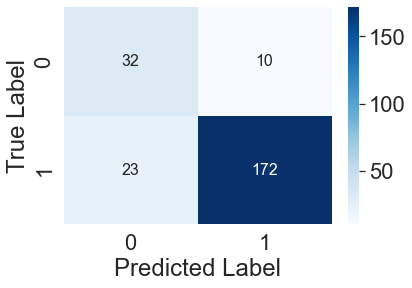

In [39]:
##Confusion matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
level= pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=2) 
d=sns.heatmap(cm, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [40]:
##fit naive bayes classifier
model2 = NaiveBayes(modelType="multinomial",smoothing=1)
pipeline2 = Pipeline(stages=[token,remove,count,model2])
nb = pipeline2.fit(train)
prediction_nb= nb.transform(test)
eval_nb=BinaryClassificationEvaluator()
auc_nb=eval_nb.evaluate(prediction)
print('Area Under ROC', auc_nb)




Area Under ROC 0.9086080586080587


In [101]:
prediction.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|               text2|               text3|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| but theres enoug...|    1|[but, theres, eno...|[theres, enough, ...|(1302,[24,242,247...|[9.37783933451508...|[0.99991542940331...|       0.0|
|A little jank but...|    1|[a, little, jank,...|[little, jank, lo...|(1302,[0,1,7,10,2...|[38.5117839679455...|           [1.0,0.0]|       0.0|
|Addictive fun and...|    1|[addictive, fun, ...|[addictive, fun, ...|(1302,[1,573],[1....|[-18.984533136250...|[5.69012772411034...|       1.0|
|All a board on th...|    1|[all, a, board, o...|[board, choo, cho...|(1302,[438,974],[...|[-20.124545837917...|[1.81978797528947.

In [41]:
##Accuracy,f1-score,recall and confusion matrix with Naive Bayes classifier

##Accuracy
pred_nb=prediction_nb.select("label","prediction")
evallnb = MulticlassClassificationEvaluator()
evallnb.setPredictionCol("prediction")
accuracy_nb=evallnb.evaluate(pred_nb)
print("Accuracy of Naive Bayes Classifier = %g"% (accuracy_nb))
print("Test Error of Naive Bayes Classifier = %g"% (1-accuracy_nb))

##f1 score
lab_true_nb = pred_nb.select(['label']).collect()
lab_pred_nb = pred_nb.select(['prediction']).collect()
print(classification_report(lab_true_nb, lab_pred_nb))
print(confusion_matrix(lab_true_nb, lab_pred_nb))


Accuracy of Naive Bayes Classifier = 0.890243
Test Error of Naive Bayes Classifier = 0.109757
              precision    recall  f1-score   support

           0       0.65      0.79      0.71        42
           1       0.95      0.91      0.93       195

    accuracy                           0.89       237
   macro avg       0.80      0.85      0.82       237
weighted avg       0.90      0.89      0.89       237

[[ 33   9]
 [ 18 177]]


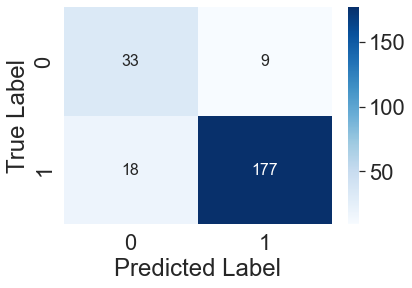

In [43]:
cmnb=confusion_matrix(lab_true_nb, lab_pred_nb)
level= pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=2) 
d=sns.heatmap(cmnb, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [44]:
##fit decision trees classifier
model3 = DecisionTreeClassifier()
pipeline3 = Pipeline(stages=[token,remove,count,model3])
dt = pipeline3.fit(train)
prediction_dt= dt.transform(test)
eval_dt=BinaryClassificationEvaluator()
auc_dt=eval_dt.evaluate(prediction_dt)
print('Area Under ROC', auc_dt)


Area Under ROC 0.6045177045177046


In [45]:
##Accuracy,f1-score,recall and confusion matrix with random forest classifier

##Accuracy
pred_dt=prediction_dt.select("label","prediction")
evalldt = MulticlassClassificationEvaluator()
evalldt.setPredictionCol("prediction")
accuracy_dt=evalldt.evaluate(pred_dt)
print("Accuracy of Decision Tree Classifier = %g"% (accuracy_dt))
print("Test Error of Decision Tree Classifier = %g"% (1-accuracy_dt))

##f1 score,recall,precision
lab_true_dt = pred_dt.select(['label']).collect()
lab_pred_dt = pred_dt.select(['prediction']).collect()
print(classification_report(lab_true_dt, lab_pred_dt))
print(confusion_matrix(lab_true_dt, lab_pred_dt))


Accuracy of Decision Tree Classifier = 0.810303
Test Error of Decision Tree Classifier = 0.189697
              precision    recall  f1-score   support

           0       0.89      0.19      0.31        42
           1       0.85      0.99      0.92       195

    accuracy                           0.85       237
   macro avg       0.87      0.59      0.62       237
weighted avg       0.86      0.85      0.81       237

[[  8  34]
 [  1 194]]


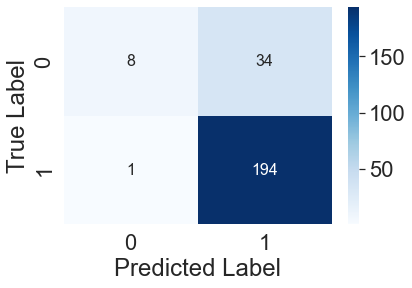

In [51]:
cmdt=confusion_matrix(lab_true_dt, lab_pred_dt)
level= pd.DataFrame(cmdt, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=2) 
d=sns.heatmap(cmdt, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [48]:
##fit random firest classifier
model4 = RandomForestClassifier()
pipeline4 = Pipeline(stages=[token,remove,count,model4])
rf = pipeline4.fit(train)
prediction_rf= rf.transform(test)
eval_rf=BinaryClassificationEvaluator()
auc_rf=eval_rf.evaluate(prediction_rf)
print('Area Under ROC', auc_rf)

Area Under ROC 0.7710622710622711


In [49]:
##Accuracy,f1-score,recall and confusion matrix with random forest classifier

##Accuracy
pred_rf=prediction_rf.select("label","prediction")
evallrf = MulticlassClassificationEvaluator()
evallrf.setPredictionCol("prediction")
accuracy_rf=evallrf.evaluate(pred_rf)
print("Accuracy of Random Forest Classifier = %g"% (accuracy_rf))
print("Test Error of Random Forest Classifier = %g"% (1-accuracy_rf))

##f1 score
lab_true_rf = pred_rf.select(['label']).collect()
lab_pred_rf = pred_rf.select(['prediction']).collect()
print(classification_report(lab_true_rf, lab_pred_rf))
print(confusion_matrix(lab_true_rf, lab_pred_rf))




Accuracy of Random Forest Classifier = 0.742792
Test Error of Random Forest Classifier = 0.257208
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.82      1.00      0.90       195

    accuracy                           0.82       237
   macro avg       0.41      0.50      0.45       237
weighted avg       0.68      0.82      0.74       237

[[  0  42]
 [  0 195]]


C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


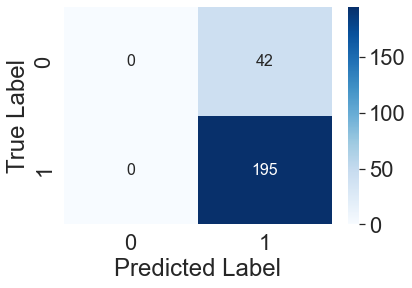

In [54]:
cmrf=confusion_matrix(lab_true_rf, lab_pred_rf)
level= pd.DataFrame(cmrf, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(cmrf, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()
                      

In [55]:
##fit gradient boosted classifier
model5 = GBTClassifier(maxIter=10)
pipeline5= Pipeline(stages=[token,remove,count,model5])
gbc = pipeline5.fit(train)
prediction_gbc= gbc.transform(test)
eval_gbc=BinaryClassificationEvaluator()
auc_gbc=eval_gbc.evaluate(prediction_gbc)
print('Area Under ROC', auc_gbc)


Area Under ROC 0.7978021978021979


In [56]:
##Accuracy,f1-score,recall and confusion matrix with gradient boosted classifier

##Accuracy
pred_gbc=prediction_gbc.select("label","prediction")
evallgbc = MulticlassClassificationEvaluator()
evallgbc.setPredictionCol("prediction")
accuracy_gbc=evallgbc.evaluate(pred_gbc)
print("Accuracy of Gradient Boosted Classifier = %g"% (accuracy_gbc))
print("Test Error of Gradient Boosted Classifier = %g"% (1-accuracy_gbc))

##f1 score
lab_true_gbc = pred_gbc.select(['label']).collect()
lab_pred_gbc = pred_gbc.select(['prediction']).collect()
print(classification_report(lab_true_gbc, lab_pred_gbc))
print(confusion_matrix(lab_true_gbc, lab_pred_gbc))

Accuracy of Gradient Boosted Classifier = 0.811961
Test Error of Gradient Boosted Classifier = 0.188039
              precision    recall  f1-score   support

           0       0.67      0.24      0.35        42
           1       0.86      0.97      0.91       195

    accuracy                           0.84       237
   macro avg       0.76      0.61      0.63       237
weighted avg       0.82      0.84      0.81       237

[[ 10  32]
 [  5 190]]


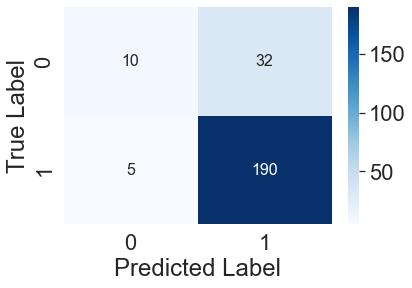

In [57]:
cmgbt=confusion_matrix(lab_true_gbc, lab_pred_gbc)
level= pd.DataFrame(cmgbt, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(cmgbt, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [20]:
from pyspark.ml.classification import LinearSVC

model6=LinearSVC(maxIter=10, regParam=0.1)
pipeline6= Pipeline(stages=[token,remove,count,model6])
lsvc = pipeline6.fit(train)
prediction_lsvc= lsvc.transform(test)
eval_lsvc=BinaryClassificationEvaluator()
auc_lsvc=eval_lsvc.evaluate(prediction_lsvc)
print('Area Under ROC', auc_lsvc)
 


Area Under ROC 0.8983516483516484


In [21]:
##Accuracy,f1-score,recall and confusion matrix with linear SVC classifier

##Accuracy
pred_svc=prediction_lsvc.select("label","prediction")
evallsvc = MulticlassClassificationEvaluator()
evallsvc.setPredictionCol("prediction")
accuracy_svc=evallsvc.evaluate(pred_svc)
print("Accuracy of linear SVC = %g"% (accuracy_svc))
print("Test Error of linear SVC = %g"% (1-accuracy_svc))

##f1 score,precision,recall
lab_true_svc = pred_svc.select(['label']).collect()
lab_pred_svc = pred_svc.select(['prediction']).collect()
print(classification_report(lab_true_svc, lab_pred_svc))
print(confusion_matrix(lab_true_svc, lab_pred_svc))

Accuracy of linear SVC = 0.842582
Test Error of linear SVC = 0.157418
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        42
           1       0.92      0.87      0.90       195

    accuracy                           0.84       237
   macro avg       0.73      0.77      0.74       237
weighted avg       0.85      0.84      0.84       237

[[ 28  14]
 [ 25 170]]


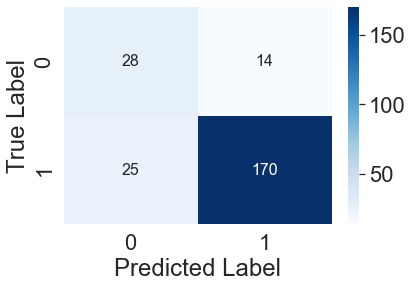

In [26]:
cmsvc=confusion_matrix(lab_true_svc, lab_pred_svc)
level= pd.DataFrame(cmsvc, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(cmsvc, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()


In [29]:
##One-vs-rest classifier

#base classifier-logistic regression for One-vs-rest classifier
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
model7 = OneVsRest(classifier=lr)
pipeline7= Pipeline(stages=[token,remove,count,model7])
ovr = pipeline7.fit(train)
prediction_ovr= ovr.transform(test)
#eval_ovr=BinaryClassificationEvaluator()
#auc_ovr=eval_ovr.evaluate(prediction_ovr)
#print('Area Under ROC', auc_ovr)
 

In [30]:
##Accuracy
#pred_ovr=prediction_ovr.select("label","prediction")
evallovr = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_ovr=evallovr.evaluate(prediction_ovr)
print("Accuracy of One-Vs-Rest Classifier = %g"% (accuracy_ovr))
print("Test Error = %g" % (1.0 - accuracy_ovr))


##f1 score and confusion matrix
lab_true_ovr = prediction_ovr.select(['label']).collect()
lab_pred_ovr = prediction_ovr.select(['prediction']).collect()
print(classification_report(lab_true_ovr, lab_pred_ovr))
print(confusion_matrix(lab_true_ovr, lab_pred_ovr))

Py4JJavaError: An error occurred while calling o3144.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 173.0 failed 1 times, most recent failure: Lost task 0.0 in stage 173.0 (TID 152) (10.46.235.68 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 59 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy$lzycompute(MulticlassMetrics.scala:188)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy(MulticlassMetrics.scala:188)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:153)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 59 more


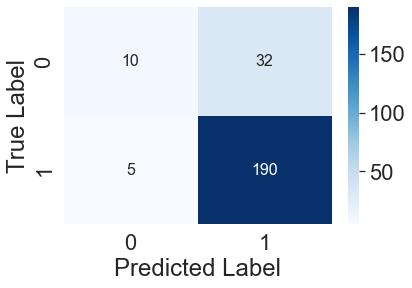

In [63]:
cmovr=confusion_matrix(lab_true_ovr, lab_pred_ovr)
level= pd.DataFrame(cmovr, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(cmovr, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [31]:
###Now use word2vec and repeat the process above 

from pyspark.ml.feature import Word2Vec
token=RegexTokenizer(inputCol="text", outputCol="text2", pattern="\\W")
remove= StopWordsRemover(inputCol=token.getOutputCol(), outputCol="text3")
w2v=Word2Vec(inputCol="text3", outputCol="features",vectorSize= 100, minCount= 0)
model=LogisticRegression()
model2=NaiveBayes(modelType="multinomial",smoothing=1)
model3=DecisionTreeClassifier()
model4=RandomForestClassifier()
model5=GBTClassifier(maxIter=10)
model6=LinearSVC(maxIter=10, regParam=0.1)
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
model7 = OneVsRest(classifier=lr)
pipeline1 = Pipeline(stages= [token,remove,w2v,model])
pipeline2 = Pipeline(stages= [token,remove,w2v,model2])
pipeline3 = Pipeline(stages= [token,remove,w2v,model3])
pipeline4 = Pipeline(stages= [token,remove,w2v,model4])
pipeline5 = Pipeline(stages= [token,remove,w2v,model5])
pipeline6 = Pipeline(stages= [token,remove,w2v,model6])
pipeline7 = Pipeline(stages= [token,remove,w2v,model7])



In [34]:
##fitting the models and making predictions


lr_wv = pipeline1.fit(train)
prediction_lr_wv= lr_wv.transform(test)

#nb_wv = pipeline2.fit(train)  ##naive Bayes is not working with Word2Vec
#prediction_nb_wv= nb_wv.transform(test)

dt_wv = pipeline3.fit(train)
prediction_dt_wv= dt_wv.transform(test)

rf_wv = pipeline4.fit(train)
prediction_rf_wv= rf_wv.transform(test)

gbc_wv = pipeline5.fit(train)
prediction_gbc_wv= gbc_wv.transform(test)

lsvc_wv= pipeline6.fit(train)
prediction_lsvc_wv= lsvc_wv.transform(test)

ovr_wv = pipeline7.fit(train)
prediction_ovr_wv= ovr_wv.transform(test)
















In [142]:
prediction_dt_wv= dt_wv.transform(test)
nb_wv = pipeline2.fit(train)
prediction_nb_wv= nb_wv.transform(test)  ##Naive Bayes is not working with word2vec

Py4JJavaError: An error occurred while calling o1380.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1094.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1094.0 (TID 1032) (10.46.235.68 executor driver): java.lang.RuntimeException: Vector values MUST NOT be Negative, NaN or Infinity, but got [-3.5843619843944907E-4,1.143665382793794E-4,-3.519348263378358E-4,2.440131849855081E-4,-3.424555406026128E-5,-2.459082881816559E-4,-5.363427367733999E-4,1.838261070790597E-4,-1.8081811463667286E-4,1.0001053063509364E-4,-3.999982824704299E-4,-8.439564391867154E-4,-5.516021661201698E-4,-5.093515711551945E-4,-6.861005911357804E-4,-3.88080985026641E-5,1.1722860088209725E-4,-6.61263656285074E-4,2.6825293187155493E-4,-2.2023555357009172E-4,-3.1708823452289734E-4,-1.7855643818620592E-5,-2.734604511513478E-4,1.3192514759591883E-4,4.908330787050847E-4,2.805259739236337E-4,1.9223266604563428E-4,1.23567969745232E-4,-2.2764063517873484E-4,-7.076301553752273E-4,6.236794231679393E-6,2.342866921228253E-4,-9.619481990941697E-4,7.721688469044035E-4,-3.16053939362367E-4,2.656221331562847E-4,-5.471269283184988E-4,-4.3285829694165534E-4,-1.1889816960319877E-4,-2.907096576463017E-5,8.219532901421189E-5,-4.970469227474596E-5,-6.635692746688922E-5,8.59491035549177E-4,-6.354417483736243E-5,1.1546562503402431E-4,4.332182288635522E-4,7.151071137438217E-5,5.716221445860962E-4,2.851764050622781E-5,1.649152060660223E-5,-2.610742166224453E-4,9.958047950122919E-5,2.0790754933841527E-4,-9.759265716032435E-5,4.438423137697908E-4,5.342397715948108E-4,-3.674044791195128E-4,-1.08897279359452E-4,-1.9934550639138452E-4,-4.937033744580629E-4,-2.823768785068144E-4,3.979036894937356E-6,8.519979245546791E-4,-9.055458293813797E-5,-2.947525936178863E-4,-2.6386563291048835E-4,-2.8086936799809337E-4,4.708440974354744E-4,7.650458656927286E-4,3.4626584965735674E-4,-5.864471523737948E-4,-4.159428256874283E-4,7.816068925118694E-4,-4.2997936058479047E-4,6.152409785297803E-4,2.082427252187497E-5,3.111958681579886E-4,-3.335202442637334E-4,-5.708756895425419E-4,-6.992324617587858E-6,2.971530387488504E-4,2.160734956204477E-4,-5.913317145314068E-4,-5.558519462485694E-4,-4.172072254328264E-5,-6.908525327970791E-4,-1.878479896630678E-5,-5.613716526163948E-4,-7.751209907130235E-5,2.2180631316991314E-4,-2.474600591489838E-4,4.4360844751483656E-4,1.013254675652004E-4,5.716359719372122E-4,-6.571152836032625E-4,7.04923392428706E-6,-1.0576288655607236E-4,4.963414491309474E-4,-5.511862206428001E-4]
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:875)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:875)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.RuntimeException: Vector values MUST NOT be Negative, NaN or Infinity, but got [-3.5843619843944907E-4,1.143665382793794E-4,-3.519348263378358E-4,2.440131849855081E-4,-3.424555406026128E-5,-2.459082881816559E-4,-5.363427367733999E-4,1.838261070790597E-4,-1.8081811463667286E-4,1.0001053063509364E-4,-3.999982824704299E-4,-8.439564391867154E-4,-5.516021661201698E-4,-5.093515711551945E-4,-6.861005911357804E-4,-3.88080985026641E-5,1.1722860088209725E-4,-6.61263656285074E-4,2.6825293187155493E-4,-2.2023555357009172E-4,-3.1708823452289734E-4,-1.7855643818620592E-5,-2.734604511513478E-4,1.3192514759591883E-4,4.908330787050847E-4,2.805259739236337E-4,1.9223266604563428E-4,1.23567969745232E-4,-2.2764063517873484E-4,-7.076301553752273E-4,6.236794231679393E-6,2.342866921228253E-4,-9.619481990941697E-4,7.721688469044035E-4,-3.16053939362367E-4,2.656221331562847E-4,-5.471269283184988E-4,-4.3285829694165534E-4,-1.1889816960319877E-4,-2.907096576463017E-5,8.219532901421189E-5,-4.970469227474596E-5,-6.635692746688922E-5,8.59491035549177E-4,-6.354417483736243E-5,1.1546562503402431E-4,4.332182288635522E-4,7.151071137438217E-5,5.716221445860962E-4,2.851764050622781E-5,1.649152060660223E-5,-2.610742166224453E-4,9.958047950122919E-5,2.0790754933841527E-4,-9.759265716032435E-5,4.438423137697908E-4,5.342397715948108E-4,-3.674044791195128E-4,-1.08897279359452E-4,-1.9934550639138452E-4,-4.937033744580629E-4,-2.823768785068144E-4,3.979036894937356E-6,8.519979245546791E-4,-9.055458293813797E-5,-2.947525936178863E-4,-2.6386563291048835E-4,-2.8086936799809337E-4,4.708440974354744E-4,7.650458656927286E-4,3.4626584965735674E-4,-5.864471523737948E-4,-4.159428256874283E-4,7.816068925118694E-4,-4.2997936058479047E-4,6.152409785297803E-4,2.082427252187497E-5,3.111958681579886E-4,-3.335202442637334E-4,-5.708756895425419E-4,-6.992324617587858E-6,2.971530387488504E-4,2.160734956204477E-4,-5.913317145314068E-4,-5.558519462485694E-4,-4.172072254328264E-5,-6.908525327970791E-4,-1.878479896630678E-5,-5.613716526163948E-4,-7.751209907130235E-5,2.2180631316991314E-4,-2.474600591489838E-4,4.4360844751483656E-4,1.013254675652004E-4,5.716359719372122E-4,-6.571152836032625E-4,7.04923392428706E-6,-1.0576288655607236E-4,4.963414491309474E-4,-5.511862206428001E-4]
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:875)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:875)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [36]:
##AUC
eval_wv=BinaryClassificationEvaluator()
auc_lr_wv=eval_wv.evaluate(prediction_lr_wv)
#auc_nb=eval_wv.evaluate(prediction_nb_wv)
auc_dt_wv=eval_wv.evaluate(prediction_dt_wv)
auc_rf_wv=eval_wv.evaluate(prediction_rf_wv)
auc_gbc_wv=eval_wv.evaluate(prediction_gbc_wv)
auc_lsvc_wv=eval_wv.evaluate(prediction_lsvc_wv)
#auc_ovr_wv=eval_wv.evaluate(prediction_ovr_wv)  ##auc for ovr is not working

print('Area Under ROC for Logistic Regression', auc_lr_wv)
#print('Area Under ROC for Naive Bayes', auc_nb_wv)
print('Area Under ROC for Decision Trees', auc_dt_wv)
print('Area Under ROC for Random Forest', auc_rf_wv)
print('Area Under ROC for Gradient Boosted Classifier', auc_gbc_wv)
print('Area Under ROC for Linear SVC', auc_lsvc_wv)
#print('Area Under ROC for One-Vs-All', auc_ovr_wv)

Area Under ROC for Logistic Regression 0.7796703296703298
Area Under ROC for Decision Trees 0.5531135531135531
Area Under ROC for Random Forest 0.6748473748473751
Area Under ROC for Gradient Boosted Classifier 0.644932844932845
Area Under ROC for Linear SVC 0.63998778998779


In [40]:
###Accuracy
pred_lr_wv=prediction_lr_wv.select("label","prediction")
evallr_wv = MulticlassClassificationEvaluator()
evallr_wv.setPredictionCol("prediction")
accuracy_lr_wv=evallr_wv.evaluate(pred_lr_wv)
print("Accuracy of Logistic Regression = %g"% (accuracy_lr_wv))
print("Test Error of Logistic Regression= %g"% (1-accuracy_lr_wv))

pred_dt_wv=prediction_dt_wv.select("label","prediction")
evaldt_wv = MulticlassClassificationEvaluator()
evaldt_wv.setPredictionCol("prediction")
accuracy_dt_wv=evaldt_wv.evaluate(pred_dt_wv)
print("Accuracy of Decision Tree Classifier = %g"% (accuracy_dt_wv))
print("Test Error of Decision Tree Classifier= %g"% (1-accuracy_dt_wv))

pred_rf_wv=prediction_rf_wv.select("label","prediction")
evalrf_wv = MulticlassClassificationEvaluator()
evalrf_wv.setPredictionCol("prediction")
accuracy_rf_wv=evalrf_wv.evaluate(pred_rf_wv)
print("Accuracy of Random Forest Classifier = %g"% (accuracy_rf_wv))
print("Test Error of Random Forest Classifier= %g"% (1-accuracy_rf_wv))

pred_gbc_wv=prediction_gbc_wv.select("label","prediction")
evalgbc_wv = MulticlassClassificationEvaluator()
evalgbc_wv.setPredictionCol("prediction")
accuracy_gbc_wv=evalgbc_wv.evaluate(pred_gbc_wv)
print("Accuracy of Gradient Boosted Classifier = %g"% (accuracy_gbc_wv))
print("Test Error of Gradient Boosted Classifier= %g"% (1-accuracy_gbc_wv))

pred_lsvc_wv=prediction_lsvc_wv.select("label","prediction")
evalsvc_wv = MulticlassClassificationEvaluator()
evalsvc_wv.setPredictionCol("prediction")
accuracy_lsvc_wv=evalsvc_wv.evaluate(pred_lsvc_wv)
print("Accuracy of linear SVC = %g"% (accuracy_lsvc_wv))
print("Test Error of linear SVC= %g"% (1-accuracy_lsvc_wv))

pred_ovr_wv=prediction_ovr_wv.select("label","prediction")
evalovr_wv = MulticlassClassificationEvaluator()
evalovr_wv.setPredictionCol("prediction")
accuracy_ovr_wv=evalovr_wv.evaluate(pred_ovr_wv)
print("Accuracy of One-Vs-All Classifier = %g"% (accuracy_ovr_wv))
print("Test Error of One-Vs-All Classifier= %g"% (1-accuracy_ovr_wv))





##One-Vs-All not working here






Accuracy of Logistic Regression = 0.797755
Test Error of Logistic Regression= 0.202245
Accuracy of Decision Tree Classifier = 0.760028
Test Error of Decision Tree Classifier= 0.239972
Accuracy of Random Forest Classifier = 0.742792
Test Error of Random Forest Classifier= 0.257208
Accuracy of Gradient Boosted Classifier = 0.735525
Test Error of Gradient Boosted Classifier= 0.264475
Accuracy of linear SVC = 0.742792
Test Error of linear SVC= 0.257208


Py4JJavaError: An error occurred while calling o6526.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 781.0 failed 1 times, most recent failure: Lost task 0.0 in stage 781.0 (TID 708) (10.46.235.68 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 59 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:66)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:64)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:227)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:235)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:235)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:152)
	at jdk.internal.reflect.GeneratedMethodAccessor199.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 59 more


In [42]:
##f1,precision,recall
lab_true_lr_wv = pred_lr_wv.select(['label']).collect()
lab_pred_lr_wv = pred_lr_wv.select(['prediction']).collect()
print(classification_report(lab_true_lr_wv, lab_pred_lr_wv))
print(confusion_matrix(lab_true_lr_wv, lab_pred_lr_wv))

lab_true_dt_wv = pred_dt_wv.select(['label']).collect()
lab_pred_dt_wv = pred_dt_wv.select(['prediction']).collect()
print(classification_report(lab_true_dt_wv, lab_pred_dt_wv))
print(confusion_matrix(lab_true_dt_wv, lab_pred_dt_wv))

lab_true_rf_wv = pred_rf_wv.select(['label']).collect()
lab_pred_rf_wv = pred_rf_wv.select(['prediction']).collect()
print(classification_report(lab_true_rf_wv, lab_pred_rf_wv))
print(confusion_matrix(lab_true_rf_wv, lab_pred_rf_wv))


lab_true_gbc_wv = pred_gbc_wv.select(['label']).collect()
lab_pred_gbc_wv = pred_gbc_wv.select(['prediction']).collect()
print(classification_report(lab_true_gbc_wv, lab_pred_gbc_wv))
print(confusion_matrix(lab_true_gbc_wv, lab_pred_gbc_wv))

lab_true_lsvc_wv = pred_lsvc_wv.select(['label']).collect()
lab_pred_lsvc_wv = pred_lsvc_wv.select(['prediction']).collect()
print(classification_report(lab_true_lsvc_wv, lab_pred_lsvc_wv))
print(confusion_matrix(lab_true_lsvc_wv, lab_pred_lsvc_wv))


#lab_true_ovr_wv = pred_ovr_wv.select(['label']).collect()
#lab_pred_ovr_wv = pred_ovr_wv.select(['prediction']).collect()
#print(classification_report(lab_true_ovr_wv, lab_pred_ovr_wv))
#print(confusion_matrix(lab_true_ovr_wv, lab_pred_ovr_wv))-ovr not working too well 




              precision    recall  f1-score   support

           0       0.62      0.19      0.29        42
           1       0.85      0.97      0.91       195

    accuracy                           0.84       237
   macro avg       0.73      0.58      0.60       237
weighted avg       0.81      0.84      0.80       237

[[  8  34]
 [  5 190]]
              precision    recall  f1-score   support

           0       0.32      0.14      0.20        42
           1       0.83      0.93      0.88       195

    accuracy                           0.79       237
   macro avg       0.58      0.54      0.54       237
weighted avg       0.74      0.79      0.76       237

[[  6  36]
 [ 13 182]]


C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.82      1.00      0.90       195

    accuracy                           0.82       237
   macro avg       0.41      0.50      0.45       237
weighted avg       0.68      0.82      0.74       237

[[  0  42]
 [  0 195]]
              precision    recall  f1-score   support

           0       0.15      0.05      0.07        42
           1       0.82      0.94      0.88       195

    accuracy                           0.78       237
   macro avg       0.49      0.50      0.48       237
weighted avg       0.70      0.78      0.74       237

[[  2  40]
 [ 11 184]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.82      1.00      0.90       195

    accuracy                           0.82       237
   macro avg       0.41      0.50      0.45       237
weighted avg       0.68     

C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
###Plot confusion matrix
lrwv=confusion_matrix(lab_true_lr_wv, lab_pred_lr_wv)
dtwv=confusion_matrix(lab_true_dt_wv, lab_pred_dt_wv)
rfwv=confusion_matrix(lab_true_rf_wv, lab_pred_rf_wv)
lsvcwv=confusion_matrix(lab_true_lsvc_wv, lab_pred_lsvc_wv)





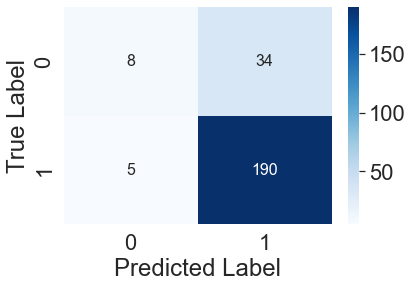

In [44]:
level= pd.DataFrame(lrwv, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(lrwv, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()


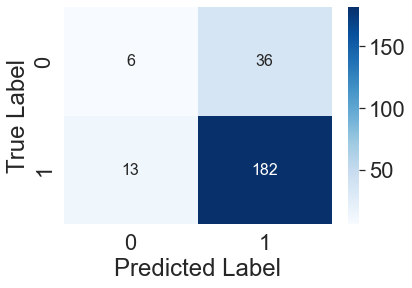

In [45]:
level= pd.DataFrame(dtwv, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(dtwv, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

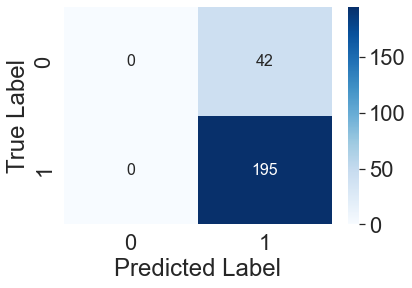

In [46]:
level= pd.DataFrame(rfwv, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(rfwv, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

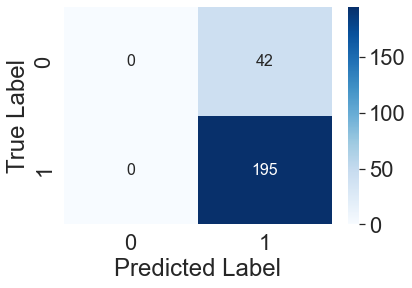

In [47]:
level= pd.DataFrame(lsvcwv, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(lsvcwv, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [48]:
token=RegexTokenizer(inputCol="text", outputCol="text2", pattern="\\W")
remove= StopWordsRemover(inputCol=token.getOutputCol(), outputCol="text3")
htf = HashingTF(inputCol="text3", outputCol="features", numFeatures=100000)
idf = IDF(inputCol="features", outputCol="tf")

pipeline1 = Pipeline(stages= [token,remove,htf,idf,model])
pipeline2 = Pipeline(stages= [token,remove,htf,idf,model2])##not working
pipeline3 = Pipeline(stages= [token,remove,htf,idf,model3])##not working
pipeline4 = Pipeline(stages= [token,remove,htf,idf,model4])##not working
pipeline5 = Pipeline(stages= [token,remove,htf,idf,model5])##not working
pipeline6 = Pipeline(stages= [token,remove,htf,idf,model6])
pipeline7 = Pipeline(stages= [token,remove,htf,idf,model7])##not working

In [56]:
##fitting the models and making predictions


lr_tf = pipeline1.fit(train)
prediction_lr_tf= lr_tf.transform(test)

nb_tf = pipeline2.fit(train)
prediction_nb_tf= nb_tf.transform(test)

dt_tf = pipeline3.fit(train)
prediction_dt_tf= dt_tf.transform(test)

rf_tf=pipeline4.fit(train)
prediction_rf_tf= rf_tf.transform(test)

gbc_tf = pipeline5.fit(train)
prediction_gbc_tf= gbc_tf.transform(test)

lsvc_tf= pipeline6.fit(train)
prediction_lsvc_tf= lsvc_tf.transform(test)

ovr_tf = pipeline7.fit(train)
prediction_ovr_tf= ovr_tf.transform(test)

In [61]:
##Accuracy
ev = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc_lr=ev.evaluate(prediction_lr_tf)
acc_nb=ev.evaluate(prediction_nb_tf)
acc_dt=ev.evaluate(prediction_dt_tf)
acc_rf=ev.evaluate(prediction_rf_tf)
acc_gbc=ev.evaluate(prediction_gbc_tf)
acc_lsvc=ev.evaluate(prediction_lsvc_tf)

#auc_lr_tf=eval_tf.evaluate(pred_lr_tf)
#auc_lsvc_tf=eval_tf.evaluate(prediction_lsvc_tf)


##Accuracy
pred_lr_tf.show(10)
print(acc_lr)
print(acc_nb)
print(acc_dt)
print(acc_rf)
print(acc_gbc)
print(acc_lsvc)
#print(acc_ovr)

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 10 rows

0.8016877637130801
0.8396624472573839
0.8523206751054853
0.8227848101265823
0.8607594936708861
0.8396624472573839


NameError: name 'acc_ovr' is not defined

In [65]:
##AUC
eval_tf=BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="prediction")
#pred_lr_tf=prediction_lr_tf.select("label","prediction")
print(eval_tf.evaluate(prediction_lr_tf))
print(eval_tf.evaluate(prediction_nb_tf))
print(eval_tf.evaluate(prediction_dt_tf))
print(eval_tf.evaluate(prediction_rf_tf))
print(eval_tf.evaluate(prediction_gbc_tf))
print(eval_tf.evaluate(prediction_lsvc_tf))


0.8234432234432235
0.5476190476190477
0.5926739926739927
0.5
0.6164835164835165
0.7811355311355311


In [75]:
##print(eval_tf.evaluate(prediction_ovr_tf))--not working


Py4JJavaError: An error occurred while calling o15593.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1966.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1966.0 (TID 1822) (10.46.235.68 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 59 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1266)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$3$lzycompute(BinaryClassificationMetrics.scala:200)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$3(BinaryClassificationMetrics.scala:181)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions$lzycompute(BinaryClassificationMetrics.scala:183)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions(BinaryClassificationMetrics.scala:183)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.createCurve(BinaryClassificationMetrics.scala:275)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.roc(BinaryClassificationMetrics.scala:106)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.areaUnderROC(BinaryClassificationMetrics.scala:126)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator.evaluate(BinaryClassificationEvaluator.scala:101)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 59 more


In [67]:
##f1 score,precision,recall
lab_true_lr_tf = prediction_lr_tf.select(['label']).collect()
lab_pred_lr_tf = prediction_lr_tf.select(['prediction']).collect()
print(classification_report(lab_true_lr_tf, lab_pred_lr_tf))
print(confusion_matrix(lab_true_lr_tf, lab_pred_lr_tf))

lab_true_nb_tf = prediction_nb_tf.select(['label']).collect()
lab_pred_nb_tf = prediction_nb_tf.select(['prediction']).collect()
print(classification_report(lab_true_nb_tf, lab_pred_nb_tf))
print(confusion_matrix(lab_true_nb_tf, lab_pred_nb_tf))

lab_true_dt_tf = prediction_dt_tf.select(['label']).collect()
lab_pred_dt_tf = prediction_dt_tf.select(['prediction']).collect()
print(classification_report(lab_true_dt_tf, lab_pred_dt_tf))
print(confusion_matrix(lab_true_dt_tf, lab_pred_dt_tf))

lab_true_rf_tf = prediction_rf_tf.select(['label']).collect()
lab_pred_rf_tf = prediction_rf_tf.select(['prediction']).collect()
print(classification_report(lab_true_rf_tf, lab_pred_rf_tf))
print(confusion_matrix(lab_true_rf_tf, lab_pred_rf_tf))

lab_true_gbc_tf = prediction_gbc_tf.select(['label']).collect()
lab_pred_gbc_tf = prediction_gbc_tf.select(['prediction']).collect()
print(classification_report(lab_true_gbc_tf, lab_pred_gbc_tf))
print(confusion_matrix(lab_true_gbc_tf, lab_pred_gbc_tf))


lab_true_lsvc_tf = prediction_lsvc_tf.select(['label']).collect()
lab_pred_lsvc_tf = prediction_lsvc_tf.select(['prediction']).collect()
print(classification_report(lab_true_lsvc_tf, lab_pred_lsvc_tf))
print(confusion_matrix(lab_true_lsvc_tf, lab_pred_lsvc_tf))

              precision    recall  f1-score   support

           0       0.47      0.86      0.61        42
           1       0.96      0.79      0.87       195

    accuracy                           0.80       237
   macro avg       0.72      0.82      0.74       237
weighted avg       0.87      0.80      0.82       237

[[ 36   6]
 [ 41 154]]
              precision    recall  f1-score   support

           0       1.00      0.10      0.17        42
           1       0.84      1.00      0.91       195

    accuracy                           0.84       237
   macro avg       0.92      0.55      0.54       237
weighted avg       0.87      0.84      0.78       237

[[  4  38]
 [  0 195]]
              precision    recall  f1-score   support

           0       0.89      0.19      0.31        42
           1       0.85      0.99      0.92       195

    accuracy                           0.85       237
   macro avg       0.87      0.59      0.62       237
weighted avg       0.86     

C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RimJhim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.82      1.00      0.90       195

    accuracy                           0.82       237
   macro avg       0.41      0.50      0.45       237
weighted avg       0.68      0.82      0.74       237

[[  0  42]
 [  0 195]]
              precision    recall  f1-score   support

           0       0.91      0.24      0.38        42
           1       0.86      0.99      0.92       195

    accuracy                           0.86       237
   macro avg       0.88      0.62      0.65       237
weighted avg       0.87      0.86      0.83       237

[[ 10  32]
 [  1 194]]
              precision    recall  f1-score   support

           0       0.54      0.69      0.60        42
           1       0.93      0.87      0.90       195

    accuracy                           0.84       237
   macro avg       0.73      0.78      0.75       237
weighted avg       0.86     

In [68]:
tflr=confusion_matrix(lab_true_lr_tf, lab_pred_lr_tf)
tfnb=confusion_matrix(lab_true_nb_tf, lab_pred_nb_tf)
tfdt=confusion_matrix(lab_true_dt_tf, lab_pred_dt_tf)
tfrf=confusion_matrix(lab_true_rf_tf, lab_pred_rf_tf)
tfgbc=confusion_matrix(lab_true_gbc_tf, lab_pred_gbc_tf)
tflsvc=confusion_matrix(lab_true_lsvc_tf, lab_pred_lsvc_tf)

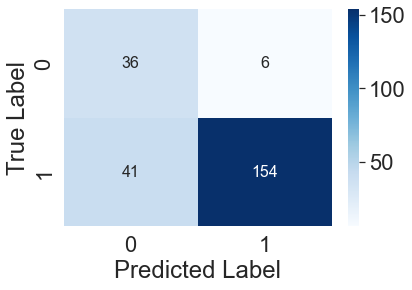

In [69]:
level= pd.DataFrame(tflr, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(tflr, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

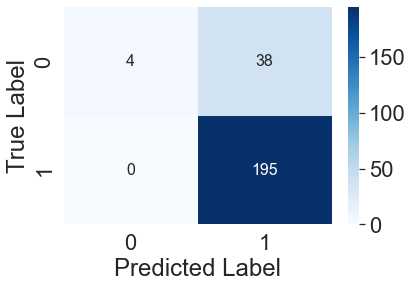

In [70]:
level= pd.DataFrame(tfnb, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(tfnb, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

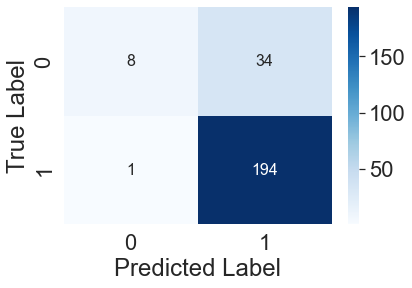

In [71]:
level= pd.DataFrame(tfdt, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(tfdt, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

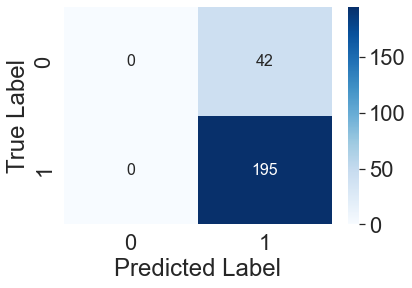

In [72]:
level= pd.DataFrame(tfrf, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(tfrf, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

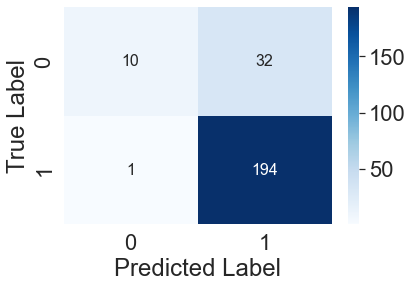

In [73]:
level= pd.DataFrame(tfgbc, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(tfgbc, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

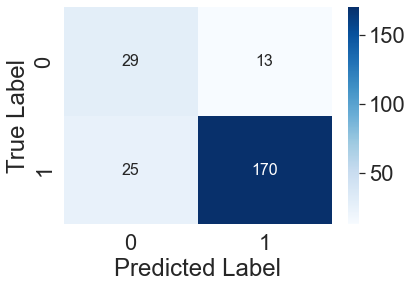

In [74]:
level= pd.DataFrame(tflsvc, range(2), range(2))
sns.set(font_scale=2) 
d=sns.heatmap(tflsvc, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="g") # font size
d.set_xlabel("Predicted Label")
d.set_ylabel("True Label")
plt.show()

In [24]:
model2.save("C:/Users/RimJhim/Desktop/sp2/new.model") ##cannot save model-so using code in full for 
###live predictions 

Py4JJavaError: An error occurred while calling o551.save.
: java.io.IOException: Path C:/Users/RimJhim/Desktop/sp2/new.model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
